# 測試聊天格式

In [1]:
# 讀取Tokenizer
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('deepseek-ai/deepseek-llm-7b-chat')
tokenizer.pad_token = tokenizer.eos_token

system_format = {"role": "system", "content": '這是系統指令'}
question_format = {"role": "user", "content": '這是用戶的輸入'}
answer_format = {"role": "assistant", "content": '這是模型回復'}

chat_format = tokenizer.apply_chat_template([system_format, question_format, answer_format, question_format, answer_format])
print(tokenizer.decode(chat_format))

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<｜begin▁of▁sentence｜>這是系統指令

User: 這是用戶的輸入

Assistant: 這是模型回復<｜end▁of▁sentence｜>User: 這是用戶的輸入

Assistant: 這是模型回復<｜end▁of▁sentence｜>


# 模型量化與載入模型

In [2]:
from accelerate import Accelerator
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch

# 初始化 Accelerator 並取得當前設備 index
accelerator = Accelerator()
device_map = {"": accelerator.local_process_index}

# 量化設定
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

# 載入模型
model = AutoModelForCausalLM.from_pretrained(
    'deepseek-ai/deepseek-llm-7b-chat',
    quantization_config=bnb_config,
    torch_dtype=torch.bfloat16,
    device_map=device_map,
    use_cache=False,
)
print(model)

Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.48s/it]


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(102400, 4096)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-06)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps

# 加載LORA

In [3]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

peft_params = {
            'r': 32,        
            'target_modules': ["q_proj", "k_proj", "v_proj", "o_proj"],
            'lora_dropout': 0.1,
            'task_type': "CAUSAL_LM",
        }
peft_config = LoraConfig(**peft_params)

model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True)
model = get_peft_model(model, peft_config)
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(102400, 4096)
        (layers): ModuleList(
          (0-29): 30 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): 

# 使用NEFtune(可不執行)

In [18]:
from transformers.modeling_utils import unwrap_model

def activate_neftune(model, neftune_noise_alpha = 5):
        unwrapped_model = unwrap_model(model)
        embeddings = unwrapped_model.base_model.model.get_input_embeddings()
        embeddings.neftune_noise_alpha = neftune_noise_alpha # 讓Embedding層的__init__多一個neftune_noise_alpha參數
        # hook embedding layer
        hook_handle = embeddings.register_forward_hook(neftune_post_forward_hook)
        
        return model
        
def neftune_post_forward_hook(module, input, output):
    # 公式來源:https://github.com/neelsjain/NEFTune
    # 論文網址:https://arxiv.org/abs/2310.05914
    if module.training: # 讓他再訓練時有用而已
        # 實現NEFtune公式
        dims = torch.tensor(output.size(1) * output.size(2))
        mag_norm = module.neftune_noise_alpha / torch.sqrt(dims) # 這裡的neftune_noise_alpha就是在__init__的參數
        output = output + torch.zeros_like(output).uniform_(-mag_norm, mag_norm)
            
    return output
model = activate_neftune(model)

# 轉換資料成模型對話格式

In [ ]:
import pandas as pd

def transform_format(questions, answers, system='你是一個zh-tw版本的聊天機器人'):
    system_format = {"role": "system", "content": system}
    return [
        [system_format, {"role": "user", "content": q}, {"role": "assistant", "content": a}]
        for q, a in zip(questions, answers)
    ]

# 讀取CSV檔案並取前5000筆
df = pd.read_csv('Gossiping-QA-Dataset-2_0.csv').head(5000)

# 提取問題和答案
questions = df['question']
answers = df['answer']

# 轉換格式
formatted_context = transform_format(questions, answers)

[{'role': 'system', 'content': '你是一個zh-tw版本的聊天機器人'},
 {'role': 'user', 'content': '有沒有跑車很常見高級轎車卻很少的八卦'},
 {'role': 'assistant', 'content': '高雄常看到賓利啊…勞斯萊斯就真的只看過兩次'}]

# 使用DataLoader加載資料

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

# 定義自定義 Dataset
class PTTDataset(Dataset):
    def __init__(self, formatted_context, tokenizer):
        self.formatted_context = formatted_context
        self.tokenizer = tokenizer

    def __getitem__(self, index):
        return self.formatted_context[index]
       
    def __len__(self):
        return len(self.formatted_context)

    def collate_fn(self, batch):
        formatted_contexts = self.tokenizer.apply_chat_template(batch, padding=True, return_dict=True, max_length=8192, return_tensors='pt', truncation=True)
        attention_mask = formatted_contexts['attention_mask']
        labels = formatted_contexts['input_ids'].clone()
        labels[attention_mask == 0] = -100
        formatted_contexts['labels'] = labels
        return formatted_contexts

# 建立資料集
trainset = PTTDataset(formatted_context, tokenizer)
validset = PTTDataset(formatted_context, tokenizer)

# 創建 DataLoader
train_loader = DataLoader(trainset, batch_size=4, shuffle=True, collate_fn=trainset.collate_fn)
valid_loader = DataLoader(validset, batch_size=4, shuffle=True, collate_fn=validset.collate_fn)

# 開始訓練

  0%|          | 0/1250 [00:00<?, ?it/s]c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
Valid Epoch 0: 100%|██████████| 1250/1250 [03:46<00:00,  5.52it/s, loss=1.926]


Saving Model With Loss 1.58931
Train Loss: 1.87485| Valid Loss: 1.58931| Best Loss: 1.58931



Valid Epoch 1: 100%|██████████| 1250/1250 [03:46<00:00,  5.51it/s, loss=1.618]


Saving Model With Loss 1.54756
Train Loss: 1.58218| Valid Loss: 1.54756| Best Loss: 1.54756



Valid Epoch 2: 100%|██████████| 1250/1250 [03:46<00:00,  5.52it/s, loss=1.328]


Saving Model With Loss 1.50835
Train Loss: 1.54623| Valid Loss: 1.50835| Best Loss: 1.50835



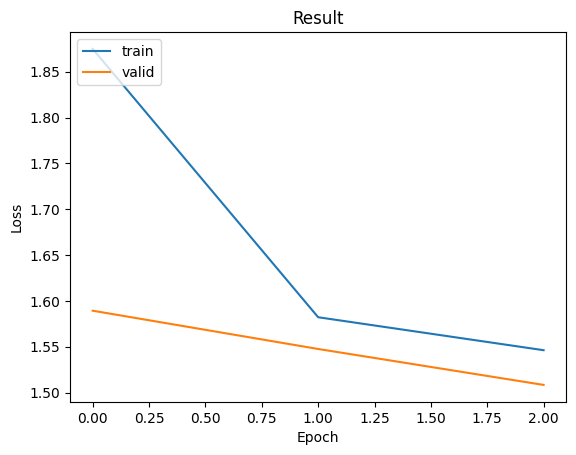

In [ ]:
import torch.optim as optim
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup
from Trainer import Trainer

# 訓練設置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=len(train_loader) * 0.2, 
        num_training_steps=len(train_loader) * 10, 
        num_cycles=1, 
)

trainer = Trainer(
    epochs=3, 
    train_loader=train_loader, 
    valid_loader=valid_loader,
    model=model, 
    optimizer=[optimizer],
    scheduler=[scheduler],
    early_stopping=3,
)
trainer.train()

# 合併訓練完畢的模型

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

# 載入 base model
base_model = AutoModelForCausalLM.from_pretrained(
    "deepseek-ai/deepseek-llm-7b-chat",
    device_map="auto",  # 自動分配 GPU/CPU
    torch_dtype=torch.bfloat16,  # 如果沒 GPU 可以改 float32
)

# 載入 PEFT 微調模型
model = PeftModel.from_pretrained(
    base_model,
    'model',  # LoRA 或其他微調權重資料夾
)

# 合併 PEFT 權重
model = model.merge_and_unload()

# 儲存合併後模型
model.save_pretrained('fine_tune_model/deepseek')

# 儲存 tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    "deepseek-ai/deepseek-llm-7b-chat",
    trust_remote_code=True,
)
tokenizer.save_pretrained('fine_tune_model/deepseek')

Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.88s/it]
Some parameters are on the meta device because they were offloaded to the cpu.
Some parameters are on the meta device because they were offloaded to the cpu.
c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\modeling_utils.py:2869: UserWarning: Attempting to save a model with offloaded modules. Ensure that unallocated cpu memory exceeds the `shard_size` (5GB default)
  warnings.warn(
Saving checkpoint shards: 100%|██████████| 3/3 [00:37<00:00, 12.62s/it]


('fine_tune_model/deepseek\\tokenizer_config.json',
 'fine_tune_model/deepseek\\special_tokens_map.json',
 'fine_tune_model/deepseek\\tokenizer.json')

# 加載訓練完後的模型

In [11]:
from accelerate import Accelerator
from transformers import AutoModelForCausalLM

device_map = {"": Accelerator().local_process_index}
model = AutoModelForCausalLM.from_pretrained(
        'fine_tune_model/deepseek',
        torch_dtype=torch.bfloat16,
        device_map=device_map,
)
print(model)

Loading checkpoint shards: 100%|██████████| 3/3 [00:08<00:00,  2.98s/it]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(102400, 4096)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-06)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-06)
      )
    )
    (n

# 進行推理

In [19]:
messages = [
    {"role": "system", "content": '你是一個zh-tw的聊天機器人'},
    {'role':'user', 'content': '你知道PTT嗎?'},
]
input_tensor = tokenizer.apply_chat_template(messages, add_generation_prompt=True, return_tensors="pt")
outputs = model.generate(input_tensor.to(model.device), max_new_tokens=100)

result = tokenizer.decode(outputs[0][input_tensor.shape[1]:], skip_special_tokens=True)
print(result)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


PTT 是台灣的網路論壇，我作為一個聊天機器人，對於PTT的了解程度取決於我的資料庫更新狀態，我會盡力提供有關PTT的資訊。
